# Predicting customer churn for telecom company

Telecom company N needs to reduce customer churn.

The company provides two main types of services:
* Landline telephone connection. The phone can be connected to several lines at the same time.
* Internet. The connection can be of two types: via a telephone line (DSL) or fiber optic cable.

Additional services:
* Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);
* Dedicated technical support line (TechSupport);
* Cloud file storage for data backup (OnlineBackup);
* Streaming television (StreamingTV) and movie catalog (StreamingMovies).

Clients can pay for services every month or sign a contract for 1–2 years. It is possible to pay the bill in different ways, as well as receive an electronic receipt.

We are provided with depersonalized customer data and data on their contracts: tariffs, connected services.

**Project goal:** predict whether the subscriber is going to terminate the contract with the company or not.

To achieve the goal of the project, we will use machine learning models that solve the problem of binary classification. ROC-AUC must be used as the quality metric (customer's requirement).

**Data overview:**
The data consists of four files. In all files, the customerID column contains a synthetic customer code, the data is depersonalized. Information about contracts is as of **February 1, 2020**.

File contract_new.csv — information about contracts:
|Column|Description|
|:--|:--|
|customerID|depersonalized customer identifier|
|BeginDate|contract start date|
|EndDate|contract expiration date|
|Type|billing period: 1 month, 1 year or 2 years|
|PaperlessBilling|electronic reciept|
|PaymentMethod|options: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)|
|MonthlyCharges|how much money customers pays every month|
|TotalCharges|sum of all the customer's payments|

File personal_new.csv — customer data:
|Column|Description|
|:--|:--|
|customerID|depersonalized customer identifier|
|gender|gender|
|SeniorCitizen|pensioner or not|
|Partner|single or married|
|Dependents|has children or not|

File internet_new.csv — information about internet services:
|Field|Description|
|:--|:--|
|customerID|depersonalized customer identifier|
|InternetService|connection type|
|OnlineSecurity|uses OnlineSecurity or not|
|OnlineBackup|uses OnlineBackup or not|
|DeviceProtection|uses antivirus or not|
|TechSupport|uses dedicated support line or not|
|StreamingTV|uses streaming TV or not|
|StreamingMovies|uses movie catalog or not|

File phone_new.csv — information about phone services:
|Column|Description|
|:--|:--|
|customerID|depersonalized customer identifier|
|MultipleLines|uses multiline or not|

**Research plan:**
1. Data loading and overview.
2. Data preprocessing.
3. Exploratory data analysis.
4. Creating a machine learning model.
5. Conclusions on the project.

## 1. Data loading and overview

At this stage, we import the libraries necessary for the research, familiarize ourselves with the data and its format, make superficial conclusions about the data problems that we will need to fix during the preprocessing stage.

In [1]:
# Update libraries
!pip install -U -q scikit-learn
!pip install -q skimpy

# Import libraries
import pandas as pd
import numpy as np
import phik
import time
from skimpy import clean_columns

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler)

from sklearn.metrics import (roc_auc_score,
                             recall_score,
                             precision_score,
                             accuracy_score)
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Setting for better graphics on high-resolution monitors
%config InlineBackend.figure_format = 'retina'

# Declare constants
RANDOM_STATE = 80424
TEST_SIZE = 0.25

In [2]:
# Load data sets
short_path = 'datasets/'
full_path = 'https://code.s3.yandex.net/datasets/'

try:
    data_contract = pd.read_csv(short_path + 'contract_new.csv')
    data_personal = pd.read_csv(short_path + 'personal_new.csv')
    data_internet = pd.read_csv(short_path + 'internet_new.csv')
    data_phone = pd.read_csv(short_path + 'phone_new.csv')
except:
    data_contract = pd.read_csv(full_path + 'contract_new.csv')
    data_personal = pd.read_csv(full_path + 'personal_new.csv')
    data_internet = pd.read_csv(full_path + 'internet_new.csv')
    data_phone = pd.read_csv(full_path + 'phone_new.csv')

Let's look at the data. What we will pay attention to first:
* whether the data corresponds to the provided description;
* number of entries;
* missing data;
* wether the data type matches the contained values.

In [3]:
# Print information about dataset
display(data_contract.head(10))
data_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Observations:**

* The dataset corresponds to the provided description (name and content of the columns).
* There are 7043 entries in the dataset, no missing data was found.
* At the preprocessing stage, it is necessary to check the `Type` and `PaymentMethod` columns for implicit duplicates, since the same category may be written with typos.
* `TotalCharges` column has object type, although it should float type. This means that the column contains data in string format along with numbers. We will fix this problem during the preprocessing stage.
* Features containing dates are not suitable for modeling in this case, so instead of `BeginDate` and `EndDate` we will create a new feature - the duration of the contract in days.
* Since our goal is to predict whether the client will terminate the contract or not, the `EndDate` column contains the target feature. If the date is presented in the cell, the client has terminated the contract; No indicates that the client continues to use the services.

In [4]:
# Print information about dataset
display(data_personal.head(10))
data_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Observations:**

* The dataset corresponds to the provided description (name and content of the columns).
* There are 7043 records in the dataset, no missing data was found. The number of records coincides with the main table, however, we must pay attention to ensure that there are no missing data after merging the two tables.
* The `SeniorCitizen` column has int type, although it is categorical in its nature. At the preprocessing stage, it is necessary to make sure that the feature contains only two unique values and convert it to Yes/No by analogy with the other categorical features.

In [5]:
# Print information about data set
display(data_internet.head(10))
data_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Observations:**

* The dataset corresponds to the provided description (name and content of the columns).
* There are 5517 records in the dataset, no missing data was found.
* A smaller number of records than in the table with contracts indicates that not all clients use Internet services, so when we merge the tables, we will get missing values, and this is expected behaviour.

In [6]:
# Print information about data set
display(data_phone.head(10))
data_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Observations:**

* The dataset corresponds to the provided description (name and content of the columns).
* There are 6361 entries in the dataset, no missing data was found.
* A smaller number of entries than in the table with contracts indicates that not all clients use telephony services,  so when we merge the tables, we will get missing values, and this is expected behaviour.
* It is important for us to save the sign of using telephone services, which will be lost when merging tables, so we need to add the `phone_service` column to the final table, similar to `internet_service`.

Now we will merge all four datasets and check the number of rows and columns in the resulting dataset.

In [7]:
# Merge datasets
data = pd.merge(data_contract, data_personal, on='customerID', how='left')
data = pd.merge(data, data_internet, on='customerID', how='left')
data = pd.merge(data, data_phone, on='customerID', how='left')

# Add column that indicates wether a client uses telephon or not
data['phone_service'] = np.where(data['customerID'].isin(data_phone['customerID']), 'Yes', 'No')

print('Size before merging:')
print('data_contract:', data_contract.shape)
print('data_personal:', data_personal.shape)
print('data_internet:', data_internet.shape)
print('data_phone:', data_phone.shape)
print('---------------------------------')
print('Size after merging:')
print('data:', data.shape, '\n')
print(data.isna().sum())

Size before merging:
data_contract: (7043, 8)
data_personal: (7043, 5)
data_internet: (5517, 8)
data_phone: (6361, 2)
---------------------------------
Size after merging:
data: (7043, 21) 

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
phone_service          0
dtype: int64


In [8]:
# Sample from the new dataset
data.sample(random_state=RANDOM_STATE).T

,15
customerID,3655-SNQYZ
BeginDate,2014-05-01
EndDate,2016-03-01
Type,Two year
PaperlessBilling,No
PaymentMethod,Credit card (automatic)
MonthlyCharges,113.25
TotalCharges,2491.5
gender,Female
SeniorCitizen,0


### Summary

* all datasets correspond to the provided description;
* initially data sets had no missing data in them;
* after merging the datasets, missing data appeared for users that don't use all the services, this is expected behaviour, at the pre-processing stage we will replace the gaps with the appropriate category;
* after merging all four datasets, we got dataset with 7043 rows (customers) and 21 columns (features).
* at the preprocessing stage, it is necessary to check the `Type` and `PaymentMethod` columns for implicit duplicates, since the same category may be written with typos;
* the `SeniorCitizen` column has int type, although it is categorical in its nature. At the preprocessing stage, it is necessary to make sure that the feature contains only two unique values and convert it to Yes/No by analogy with the other categorical features;
* `TotalCharges` column has object type, although it should float type. This means that the column contains data in string format along with numbers. We will fix this problem during the preprocessing stage;
* features containing dates are not suitable for modeling in this case, so instead of `BeginDate` and `EndDate` we will create a new feature - the duration of the contract in days;
* since our goal is to predict whether the client will terminate the contract or not, the `EndDate` column contains the target feature. If the date is presented in the cell, the client has terminated the contract; No indicates that the client continues to use the services.

A preliminary review of the data has been completed. We can start preprocessing the data.

##  2. Data preprocessing

At this stage, we clean the data, make it more suitable for research by addressing issues such as:
* incorrect column names;
* duplicates (explicit and implicit);
* empty cells;
* incorrect data format in cells;
* incorrect data.

Let's convert the column names to snake_case — this does not affect the research results but makes the code easier to read and maintain.

In [9]:
# Convert column names to snake_case
data = clean_columns(data)
print(data.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'phone_service'],
      dtype='object')


Let's check for duplicates. First, we will check for duplicates in `customer_id`.

In [10]:
print('Duplicated customer_id:', data.duplicated(subset=['customer_id']).sum())

Duplicated customer_id: 0


The `customer_id` column contains only unique values and since this field has no practical use for our modeling, we will set it as index of our dataframe.

In [11]:
# Set customer_id as DF index
data = data.set_index('customer_id')

Let's check dataset for explicit duplicates (identical rows).

In [12]:
print('Explicit duplicates:', data.duplicated().sum())

Explicit duplicates: 4


Only 4 explicit duplicates were detected. Since this is an insignificant portion of our dataset, removing these duplicates will not lead to distortions at the exploratory analysis stage.

In [13]:
# Delete explicit duplicates
data = data.drop_duplicates()

Date columns are not suitable for modeling in our case. We will create a target feature `target_contract_cancelled` based on the column `end_date`: if the column contains No, the target feature value = 0, if it contains a date, then the target feature value = 1.

We will also create a new attribute `contract_duration` - the duration of the contract in days, calculated as the difference between `end_date` and `begin_date`. If `end_date=='No'`, then replace it with 2020-02-01, the date of collection of the dataset.

In [14]:
# Create new column for target feature
data['target_contract_cancelled'] = np.where(data['end_date']=='No', 0, 1)

# Create new feature contract_duration
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = np.where(data['end_date']=='No', '2020-02-01', data['end_date'])
data['end_date'] = pd.to_datetime(data['end_date'])
data['contract_duration'] = (data['end_date'] - data['begin_date']).dt.days

data.sample(5, random_state=RANDOM_STATE).T

customer_id,3655-SNQYZ,3910-MRQOY,6575-SUVOI,7587-AOVVU,2568-BRGYX
begin_date,2014-05-01 00:00:00,2014-02-01 00:00:00,2018-01-01 00:00:00,2017-11-01 00:00:00,2019-07-01 00:00:00
end_date,2016-03-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00
type,Two year,Two year,Month-to-month,Month-to-month,Month-to-month
paperless_billing,No,No,Yes,No,Yes
payment_method,Credit card (automatic),Bank transfer (automatic),Credit card (automatic),Electronic check,Electronic check
monthly_charges,113.25,19.4,69.5,100.75,70.2
total_charges,2491.5,1536.48,1807.0,2965.07,515.97
gender,Female,Female,Female,Male,Male
senior_citizen,0,0,1,0,0
partner,Yes,Yes,Yes,Yes,No


New features were created correctly.

When we merged our datasets, we got missing values, this is expected behaviour as not all clients use all types of services. We will replace missing values with No in the new dataset.

In [15]:
# Fill the gaps
data = data.fillna('No')

Now let's find out why quantitative feature `total_charges` has object type.

In [16]:
# Create temporary column that will save only numeric values
# non-numeric values will become NaN
data['temp_column'] = pd.to_numeric(data['total_charges'], errors='coerce')

# Count incorrect rows
print('Incorrect rows in total_charges:', data['temp_column'].isna().sum())

Incorrect rows in total_charges: 11


In [17]:
# Print rows with incorrect values in total_charges
data[data['temp_column'].isna()].T

customer_id,4472-LVYGI,3115-CZMZD,5709-LVOEQ,4367-NUYAO,1371-DWPAZ,7644-OMVMY,3213-VVOLG,2520-SGTTA,2923-ARZLG,4075-WKNIU,2775-SEFEE
begin_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00
type,Two year,Two year,Two year,Two year,Two year,Two year,Two year,Two year,One year,Two year,Two year
paperless_billing,Yes,No,No,No,No,No,No,No,Yes,No,Yes
payment_method,Bank transfer (automatic),Mailed check,Mailed check,Mailed check,Credit card (automatic),Mailed check,Mailed check,Mailed check,Mailed check,Mailed check,Bank transfer (automatic)
monthly_charges,52.55,20.25,80.85,25.75,56.05,19.85,25.35,20.0,19.7,73.35,61.9
total_charges,,,,,,,,,,,
gender,Female,Male,Female,Male,Female,Male,Male,Female,Male,Female,Male
senior_citizen,0,0,0,0,0,0,0,0,0,0,0
partner,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No


We can see that incorrect values in `total_charges` appeared for contracts that started the same month as the date of the collection of the dataset. In this situation, we can either fill `total_charges` with values from `monthly_charges` or delete the rows.

Since we have only 11 rows with incorrect values, we will delete them. We will also delete the temporary column, `begin_date` and `end_date`, as we will not need them anymore.

In [18]:
# Delete incorrect rows
data = data.loc[~data['temp_column'].isna()]

# Convert total_charges to float
data['total_charges'] = data['total_charges'].astype('float')

# Delete temp_column, begin_date, end_date
data = data.drop(['begin_date','end_date', 'temp_column'], axis=1)

Now we will begin to look at each categorical feature individually.

In [19]:
# Print all unique categories in each column
for column in data.select_dtypes(include='object').columns:
    print(data[column].value_counts(),'\n')

type
Month-to-month    3873
Two year          1683
One year          1472
Name: count, dtype: int64 

paperless_billing
Yes    4167
No     2861
Name: count, dtype: int64 

payment_method
Electronic check             2365
Mailed check                 1601
Bank transfer (automatic)    1542
Credit card (automatic)      1520
Name: count, dtype: int64 

gender
Male      3546
Female    3482
Name: count, dtype: int64 

partner
No     3637
Yes    3391
Name: count, dtype: int64 

dependents
No     4930
Yes    2098
Name: count, dtype: int64 

internet_service
Fiber optic    3095
DSL            2416
No             1517
Name: count, dtype: int64 

online_security
No     5014
Yes    2014
Name: count, dtype: int64 

online_backup
No     4604
Yes    2424
Name: count, dtype: int64 

device_protection
No     4611
Yes    2417
Name: count, dtype: int64 

tech_support
No     4989
Yes    2039
Name: count, dtype: int64 

streaming_tv
No     4326
Yes    2702
Name: count, dtype: int64 

streaming_movies
No   

No implicit duplicates were detected.

The categorical feature `senior_citizen` has int type. Let's see which values it can have.

In [20]:
data['senior_citizen'].value_counts()

senior_citizen
0    5886
1    1142
Name: count, dtype: int64

Let's replace 0 with No and 1 with Yes, as has been done with other categorical features.

In [21]:
# Convert senior-citizen categories to Yes/No
data['senior_citizen'] = data['senior_citizen'].map({1: 'Yes', 0: 'No'})

# Convert data type to category
for column in data.select_dtypes(include='object').columns.to_list():
    data[column] = data[column].astype('category')

Data preprocessing is completed. Let's display information on the dataset.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   type                       7028 non-null   category
 1   paperless_billing          7028 non-null   category
 2   payment_method             7028 non-null   category
 3   monthly_charges            7028 non-null   float64 
 4   total_charges              7028 non-null   float64 
 5   gender                     7028 non-null   category
 6   senior_citizen             7028 non-null   category
 7   partner                    7028 non-null   category
 8   dependents                 7028 non-null   category
 9   internet_service           7028 non-null   category
 10  online_security            7028 non-null   category
 11  online_backup              7028 non-null   category
 12  device_protection          7028 non-null   category
 13  tech_support           

### Preprocessing results

* Column names have been converted to snake_case. This will not affect the research results but will improve code readability and maintainability.
* Four explicit duplicates have been removed.
* A new numerical feature, contract duration in days (`contract_duration`), has been created based on the `begin_date` and `end_date` features.
* A target feature, `target_contract_cancelled`, has been created based on the `end_date` feature. It takes the value 0 if `end_date` contains No and 1 if `end_date` contains a contract termination date.
* The date features `begin_date` and `end_date` have been removed, as they are not suitable for modeling in this task.
* Eleven entries with missing `total_charges` data have been removed.
* Categorical features have been converted to the category type.
* After preprocessing, the dataset contains 7028 entries and 20 features.

## 3. Exploratory data analysis

At this stage, we will explore the distribution of features, identify and eliminate anomalies in the data, and search for relationships between features.

Before we start, we will create functions for diagrams and plots to avoid repeating the same code multiple times.

In [23]:
# Function for histograms
def draw_norm_histogram(data, column, major_ticks=10, minor_ticks=2, target=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    ax.set_xlabel(f'Feature {column}')
    ax.set_ylabel('Density')
    ax.grid()
    if target==None:
        ax.set_title(f'Density histogram of the {column} feature',
                     fontweight='semibold')
        sns.histplot(data,
                     x=column,
                     stat='density',
                     common_norm=False,
                     ax=ax,
                     color='#e84a9b')
    else:
        ax.set_title(f'Density histogram of the {column} feature, taking into account the target',
                     fontweight='semibold')
        sns.histplot(data[data[target]==0],
                     x=column,
                     stat='density',
                     common_norm=False,
                     ax=ax,
                     color='#e84a9b',
                     alpha=0.7,
                     label='Active contracts')
        median_0 = data[data[target]==0][column].median()
        plt.axvline(x=median_0, color='r', linestyle='--', label='Median for Active')
        sns.histplot(data[data[target]==1],
                     x=column,
                     stat='density',       
                     common_norm=False,
                     ax=ax,
                     color='lightgray',
                     alpha=0.3,
                     label='Terminated contracts')
        median_1 = data[data[target]==1][column].median()
        plt.axvline(x=median_1, color='black', linestyle='--', label='Median for Terminated')
        plt.legend()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_ticks))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_ticks))
    plt.show()
    
# Function for descriptive statistics
def show_description(data, column):
    display(pd.DataFrame({column: data[column].describe().round(2)}))
    
# Function for boxplots
def draw_boxplot(data, column, major_ticks=10, minor_ticks=2):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,2))
    ax.set_title(f'Box plot of the {column} feature',
                 fontweight='semibold')
    sns.boxplot(x=column, data=data, ax=ax, color='#e84a9b')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_ticks))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_ticks))
    plt.show()

### Target feature `target_contract_cancelled`

First, let's examine the distribution of the target feature.

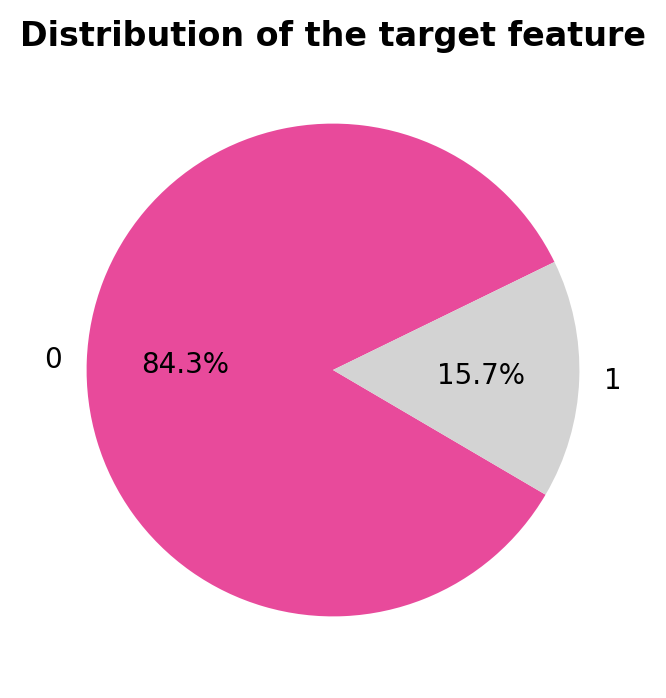

In [24]:
# Piechart
fig, ax = plt.subplots(figsize = (4,4))
class_counts = pd.Series(data['target_contract_cancelled']).value_counts()
ax.set_title('Distribution of the target feature',
             fontweight='semibold')
ax.pie(class_counts,
       labels=class_counts.index,
       colors=['#e84a9b', 'lightgray'],
       autopct='%1.1f%%',
       startangle=26)
plt.show()

The feature takes only two values. The problem that we need to solve is a binary classification task.

There is a significant class imbalance: in the dataset, 84.3% of customers have active contracts, while only 15.7% have terminated their contracts. Since the required quality metric is ROC-AUC, this will not affect its value. However, we will still stratify the samples so that the model learns better, and other metrics (recall, precision) are also at a high level.

### Feature `monthly_charges`

We will draw a density histogram to visually assess the distribution of the feature, display descriptive statistics, and create a box plot to determine if there are any outliers.

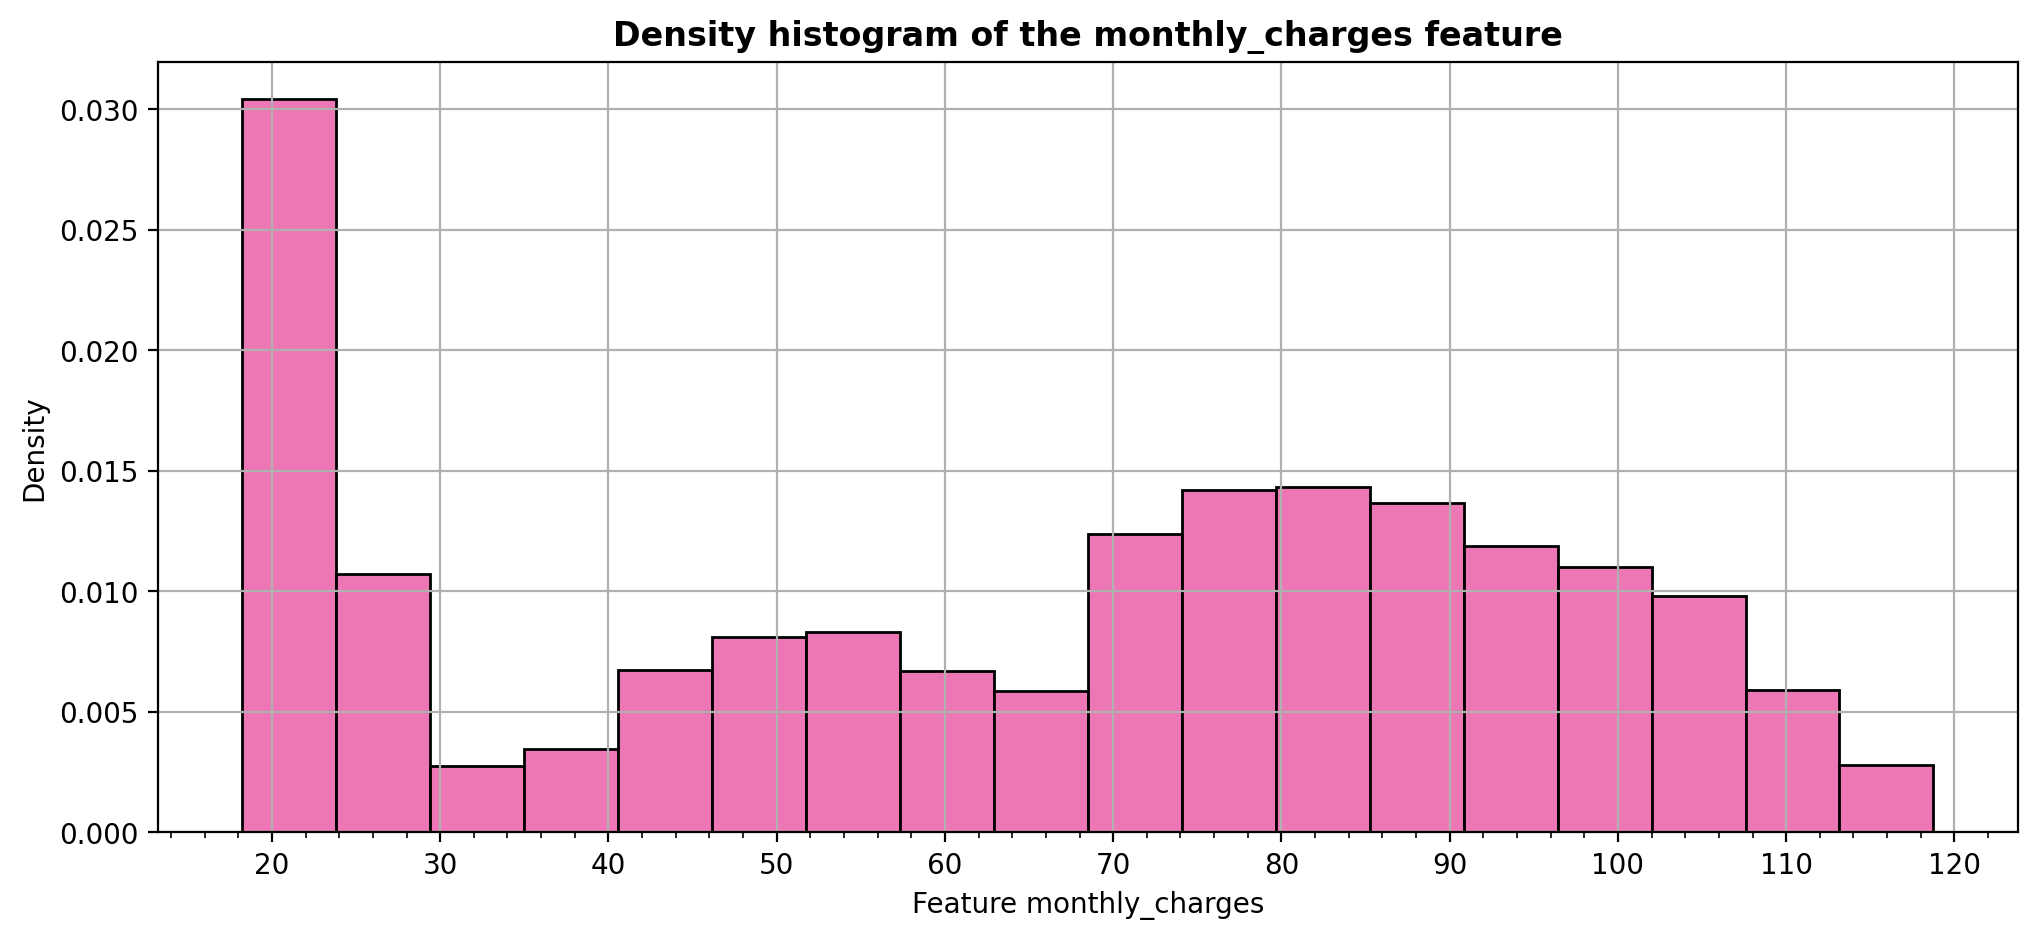

,monthly_charges
count,7028.00
mean,64.81
std,30.08
min,18.25
25%,35.65
50%,70.35
75%,89.86
max,118.75


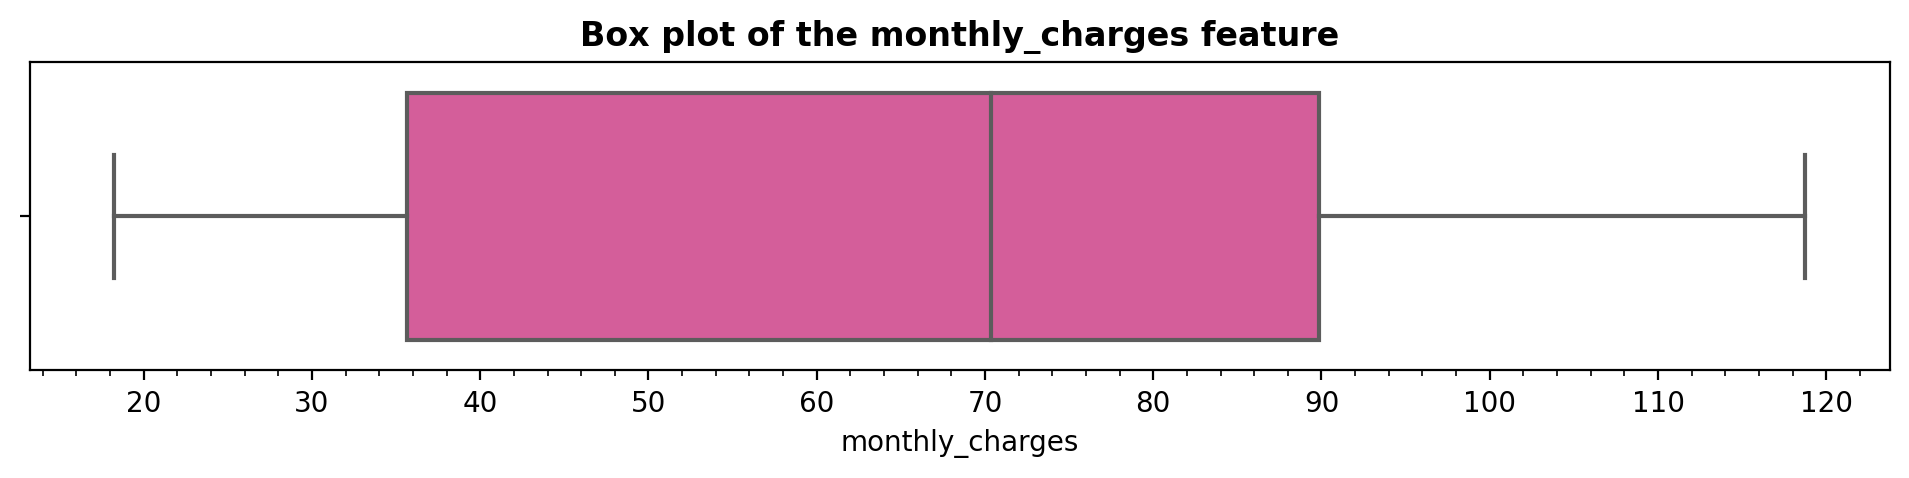

In [25]:
draw_norm_histogram(data=data, column='monthly_charges')
show_description(data=data, column='monthly_charges')
draw_boxplot(data=data, column='monthly_charges')

Let's see how `monthly_charges` distribution differ, taking into account the target feature.

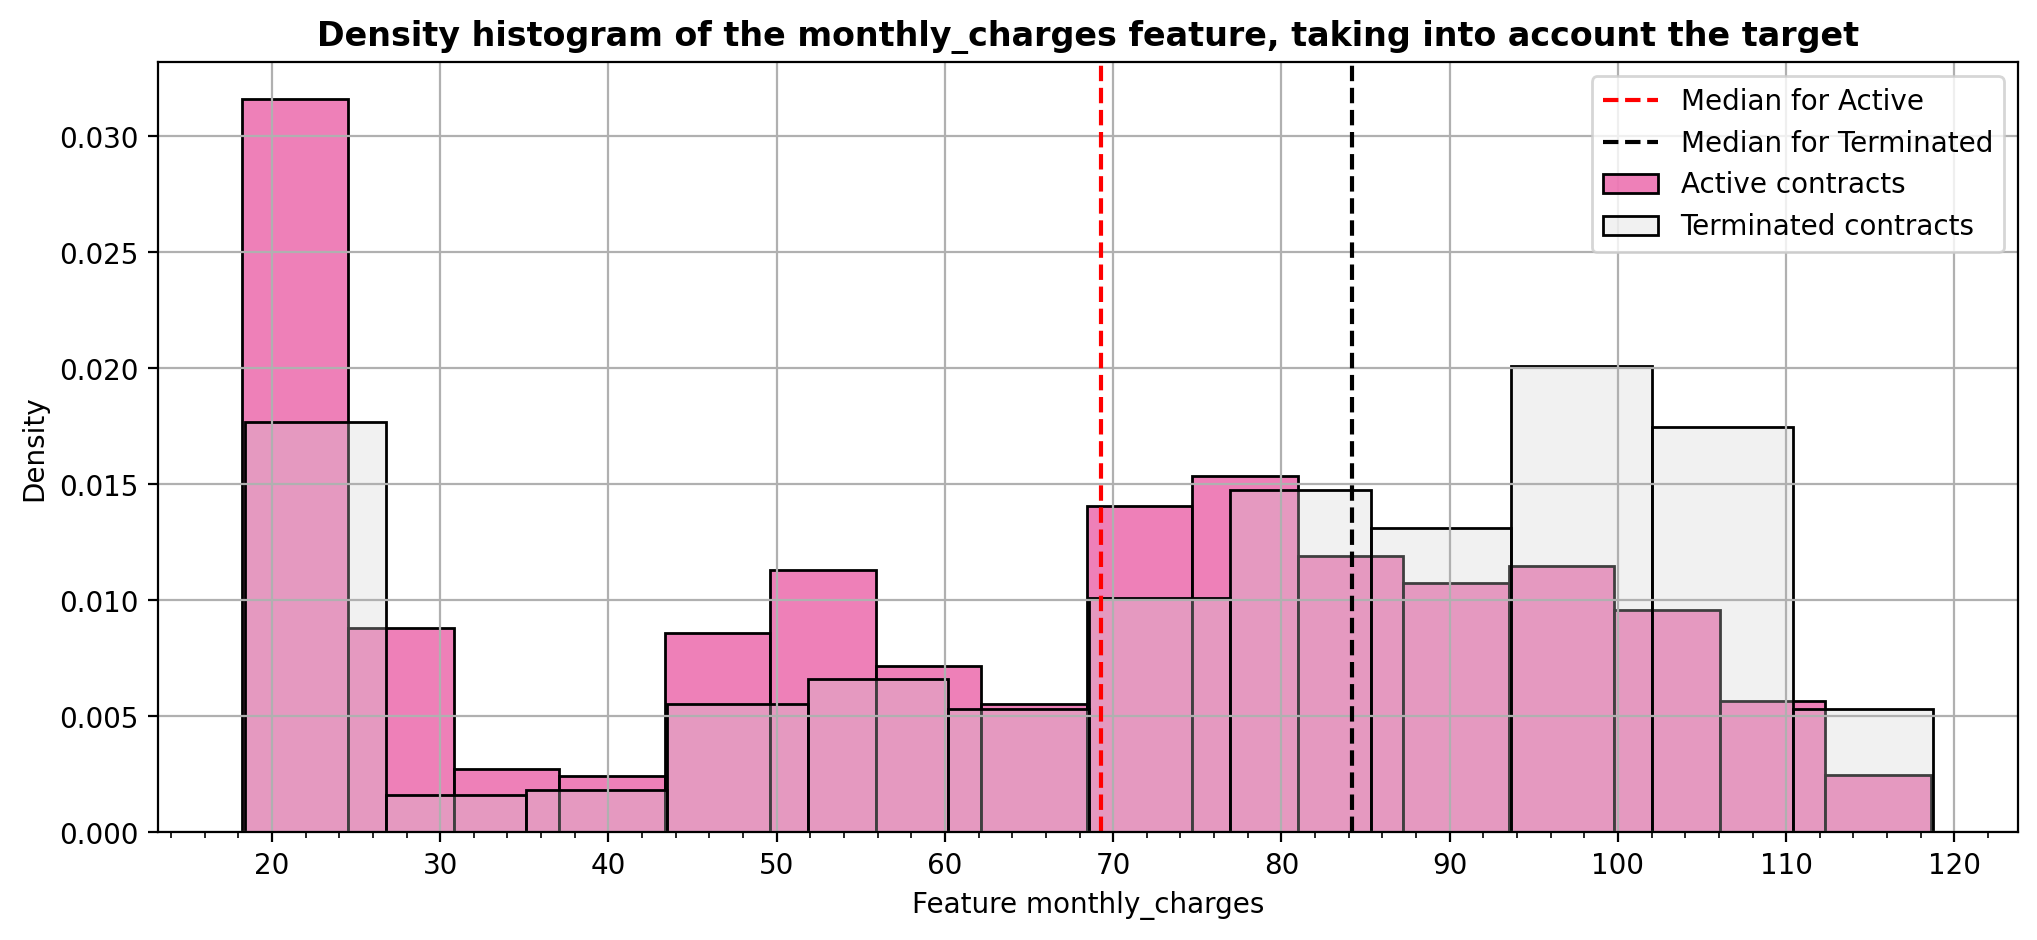

In [26]:
draw_norm_histogram(data=data, 
                    column='monthly_charges',
                    target='target_contract_cancelled')

In [27]:
print('Median for Active contracts:',
      data[data['target_contract_cancelled']==0]['monthly_charges'].median())
print('Median for Terminated contracts:', 
      data[data['target_contract_cancelled']==1]['monthly_charges'].median())

Median for Active contracts: 69.25
Median for Terminated contracts: 84.2


**Observations:**

* The feature is non-normally distributed.
* It takes values from 18.25 to 118.75.
* The median value is 70.35.
* The highest density of the distribution is concentrated in the range from 18.25 to ~24.
* There are no outliers or anomalies observed.
* The median monthly charges and the density of the distribution in the range from 68 to 120 for terminated contracts are higher than for active contracts.
* The median for active contracts is 69.25, while for terminated contracts it is 84.2.

### Feature `total_charges`

Let's repeat the same actions.

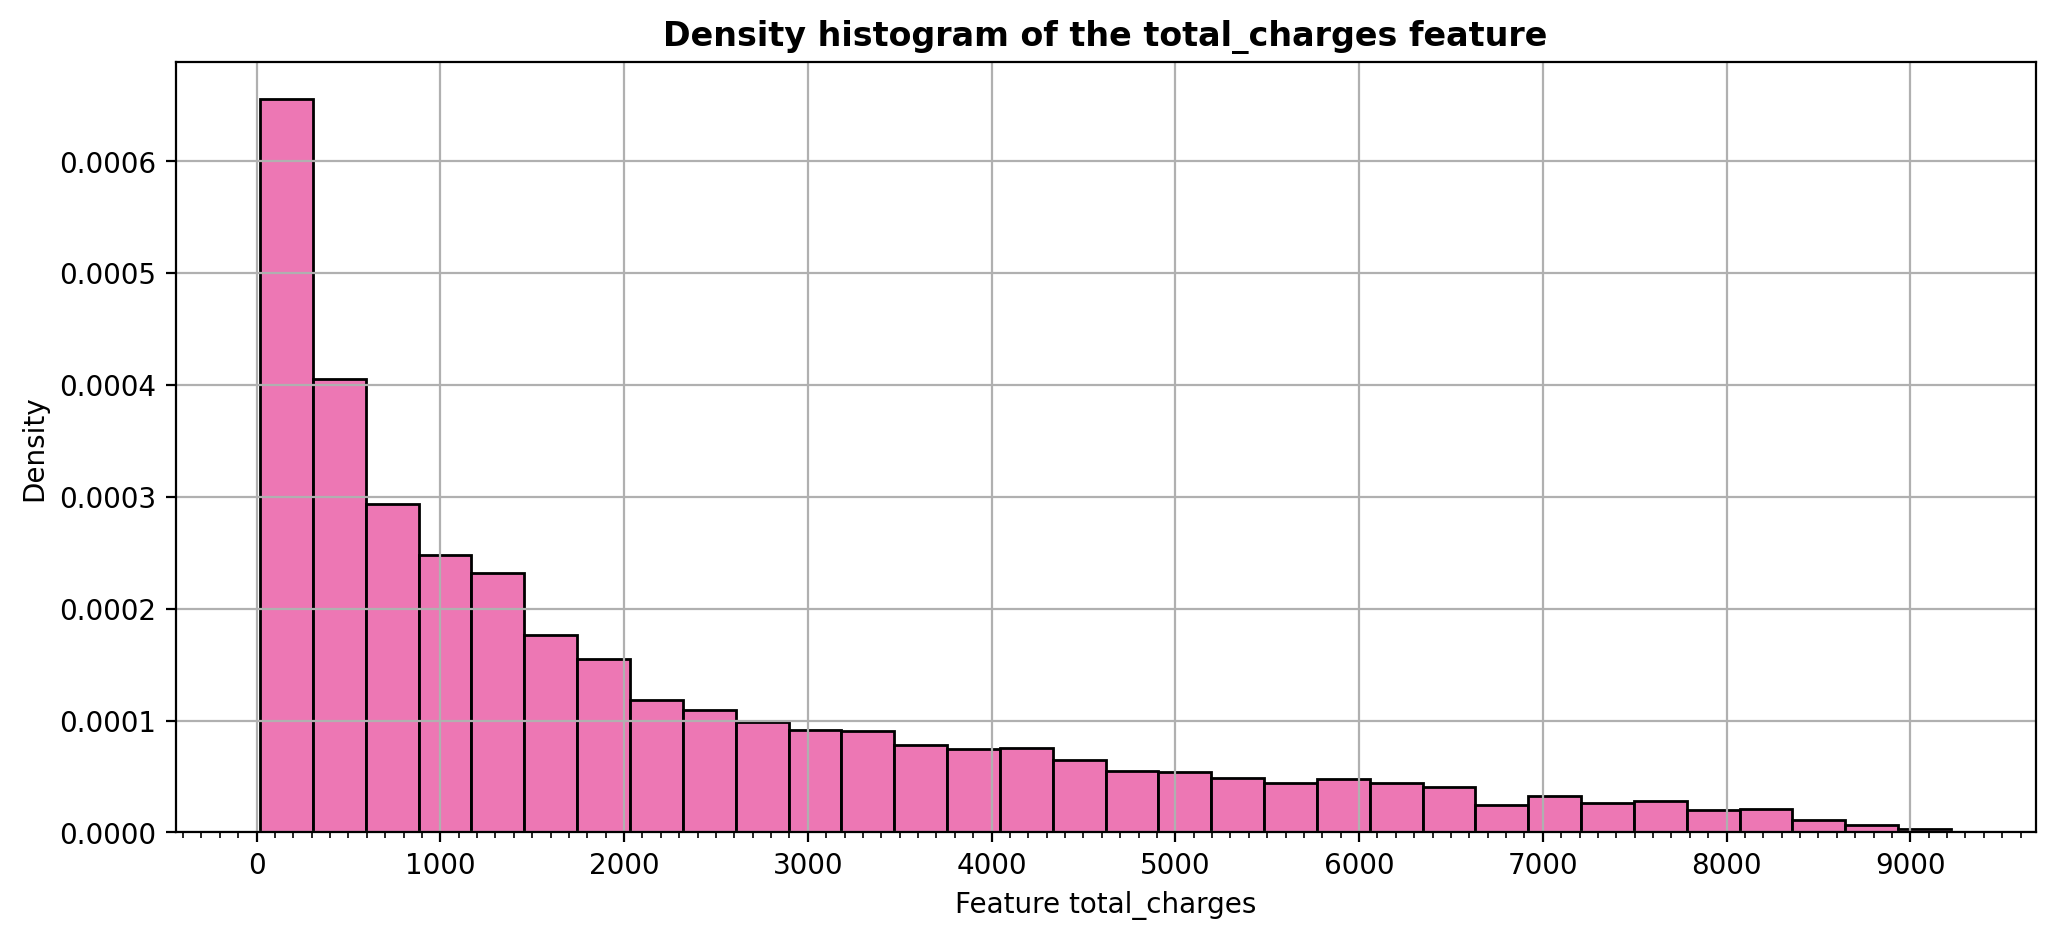

,total_charges
count,7028.00
mean,2118.39
std,2111.79
min,19.05
25%,439.99
50%,1345.28
75%,3239.32
max,9221.38


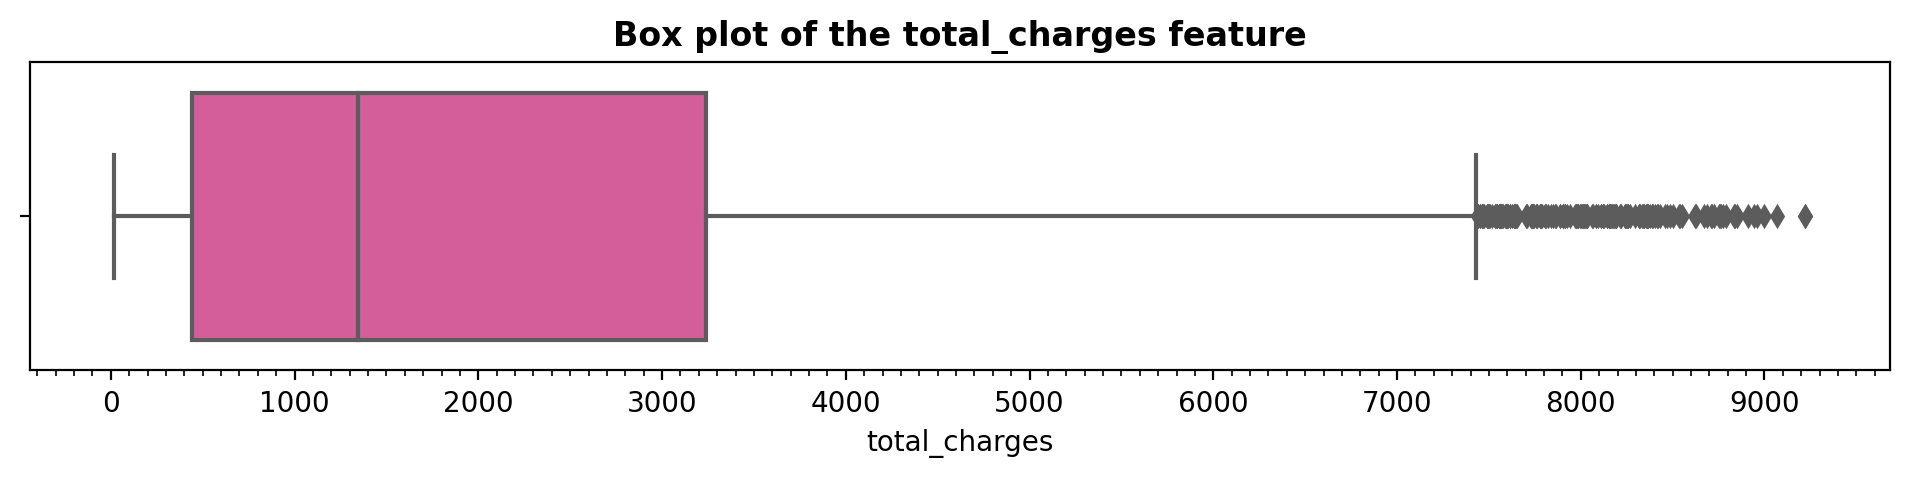

In [28]:
draw_norm_histogram(data=data, column='total_charges', major_ticks=1000, minor_ticks=100)
show_description(data=data, column='total_charges')
draw_boxplot(data=data, column='total_charges', major_ticks=1000, minor_ticks=100)

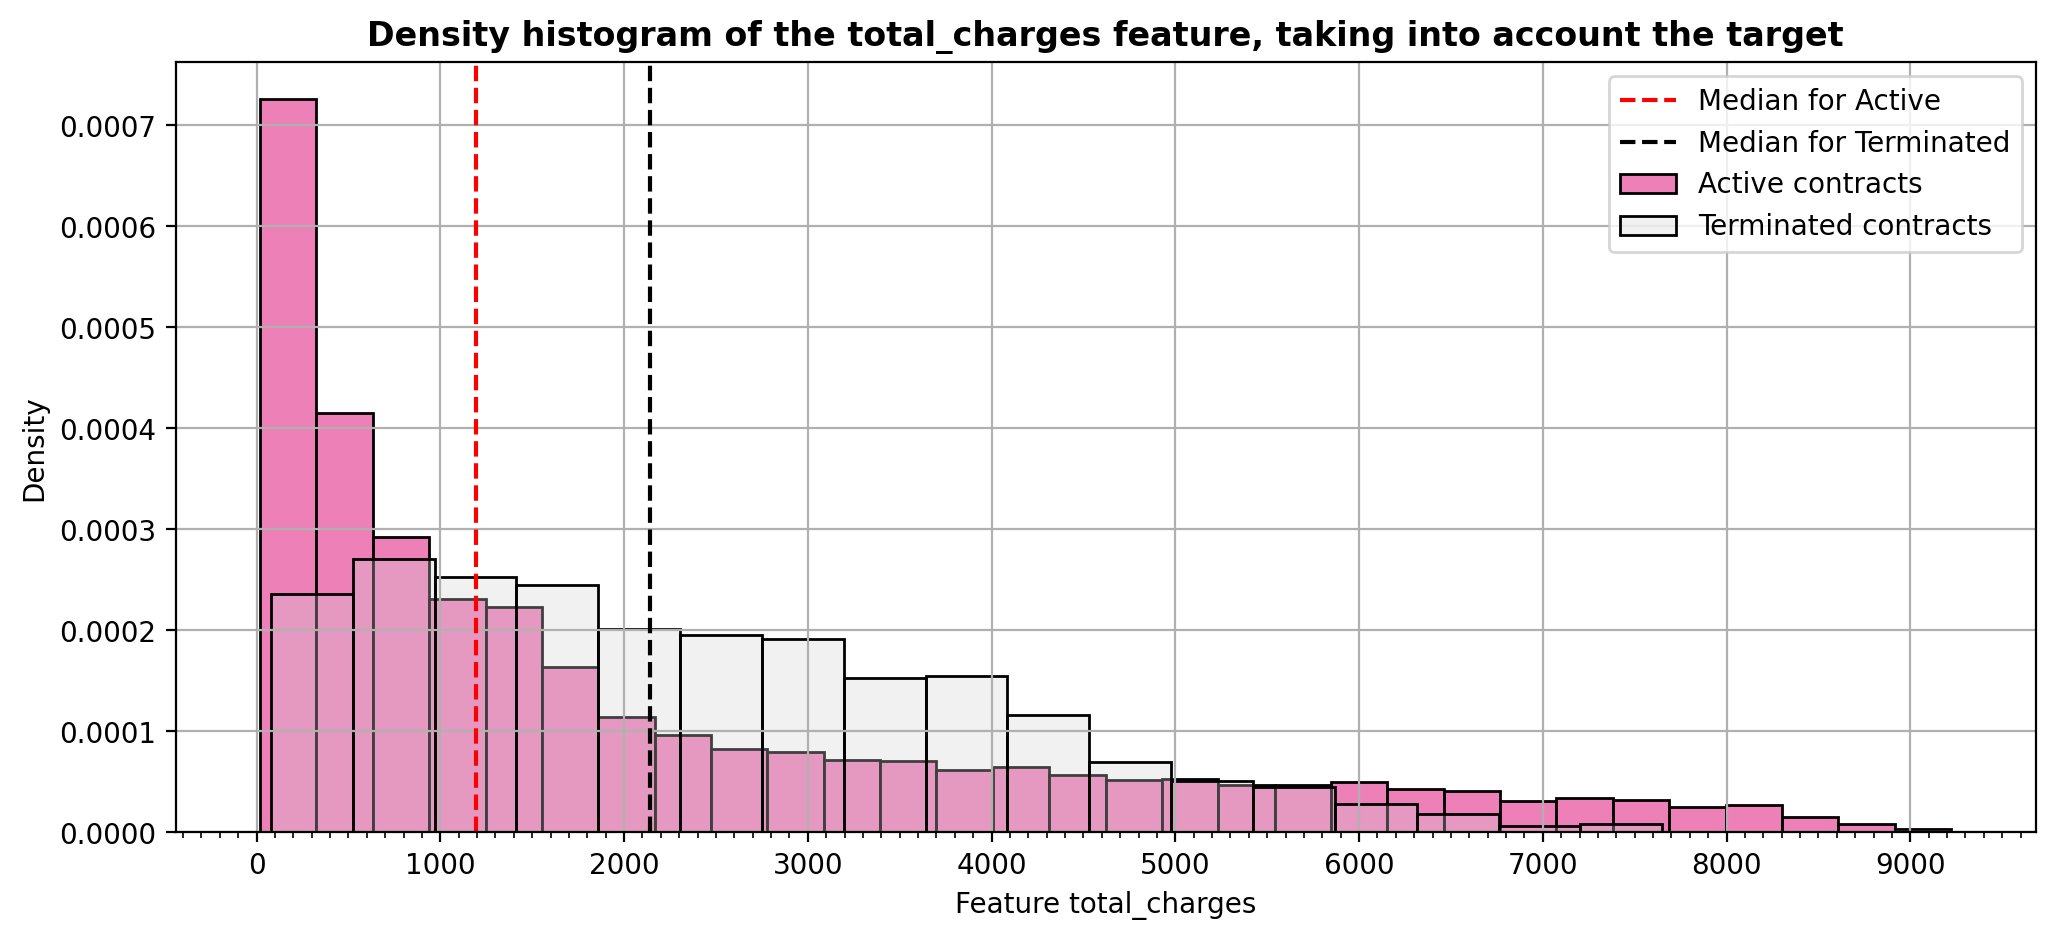

In [29]:
draw_norm_histogram(data=data, 
                    column='total_charges', 
                    major_ticks=1000, 
                    minor_ticks=100,
                    target='target_contract_cancelled')

In [30]:
print('Median for Active contracts:',
      data[data['target_contract_cancelled']==0]['total_charges'].median())
print('Median for Terminated contracts:', 
      data[data['target_contract_cancelled']==1]['total_charges'].median())

Median for Active contracts: 1194.28
Median for Terminated contracts: 2139.03


**Observations:**

* The feature is non-normally distributed.
* It takes values from 19.05 to 9221.38.
* The median value is 1345.28.
* The highest density of the distribution is concentrated in the range from 19.05 to ~300.
* A large number of outliers above the interquartile range boundary are observed. This may be explained by the presence of a large number of long-term customers.
* The median total charges and the density of the distribution in the range from 0 to 5000 for terminated contracts are higher than for active contracts.
* The median for active contracts is 1194.28, while for terminated contracts it is 2139.03.

### Feature `contract_duration`

Let's repeat the same actions.

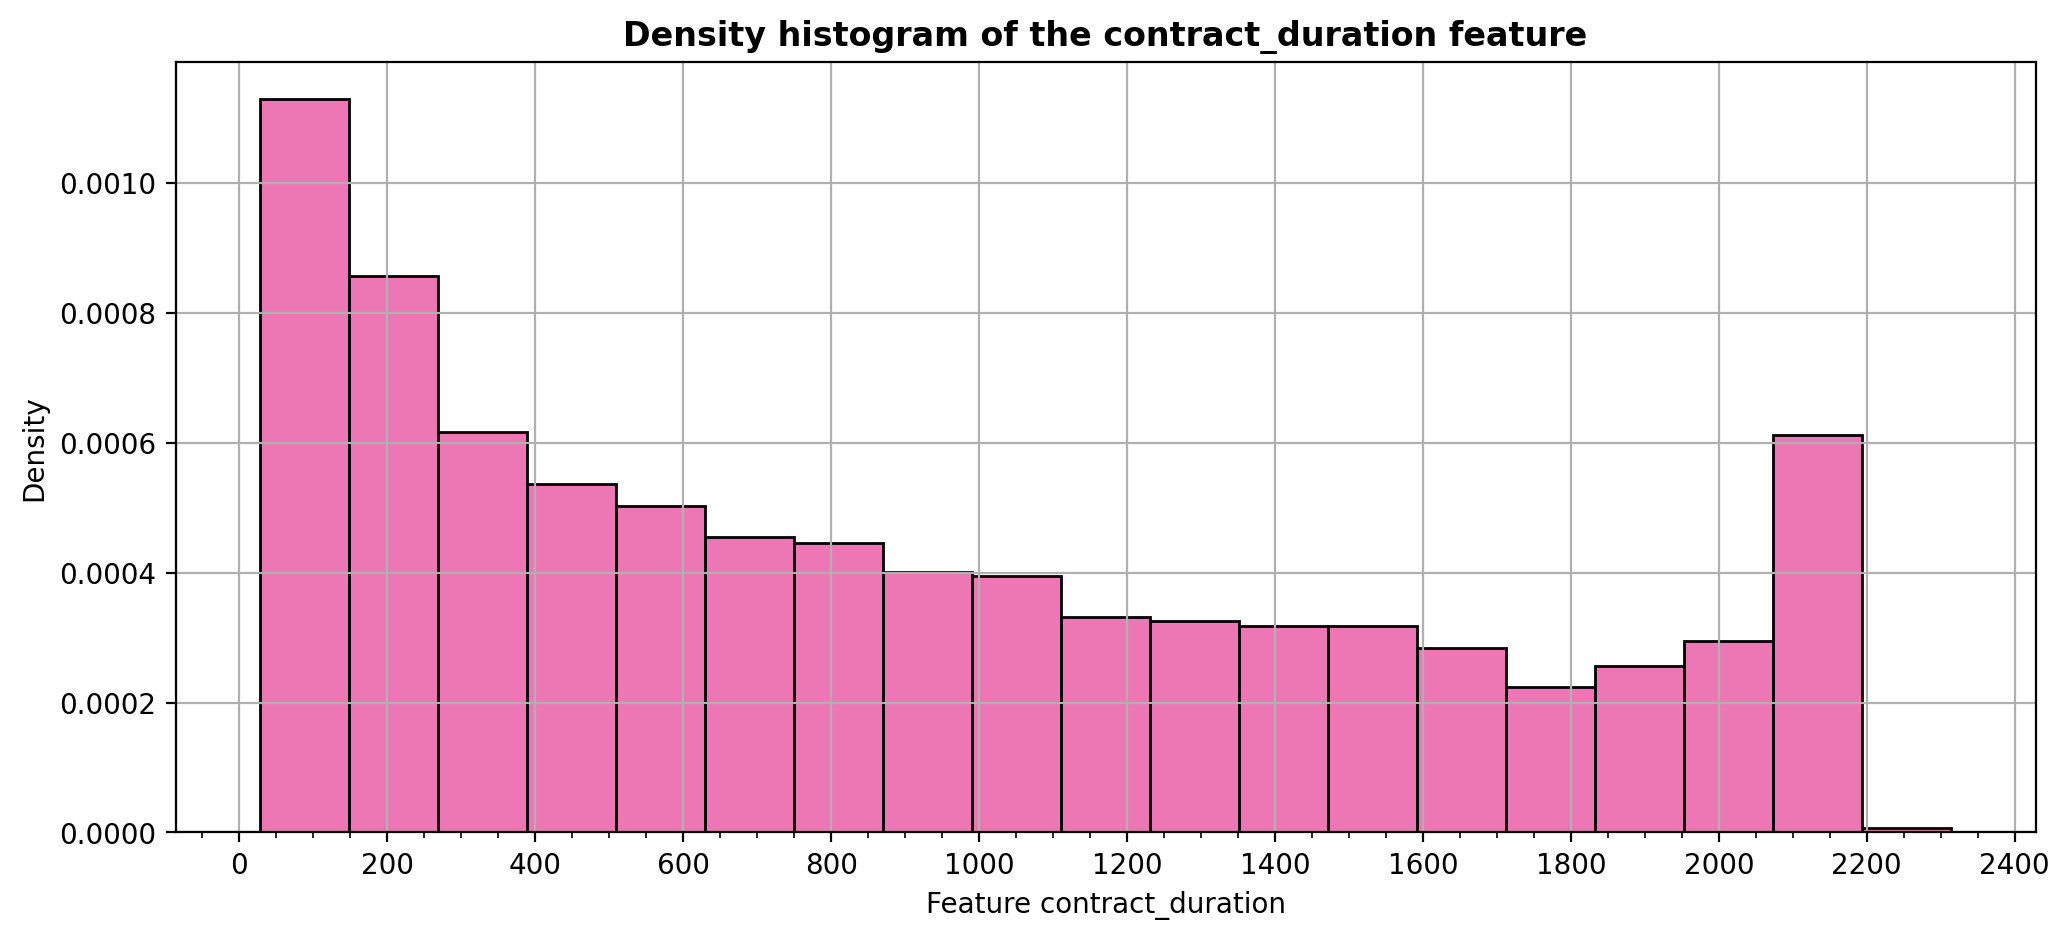

,contract_duration
count,7028.00
mean,899.84
std,682.43
min,28.00
25%,276.00
50%,761.00
75%,1461.00
max,2314.00


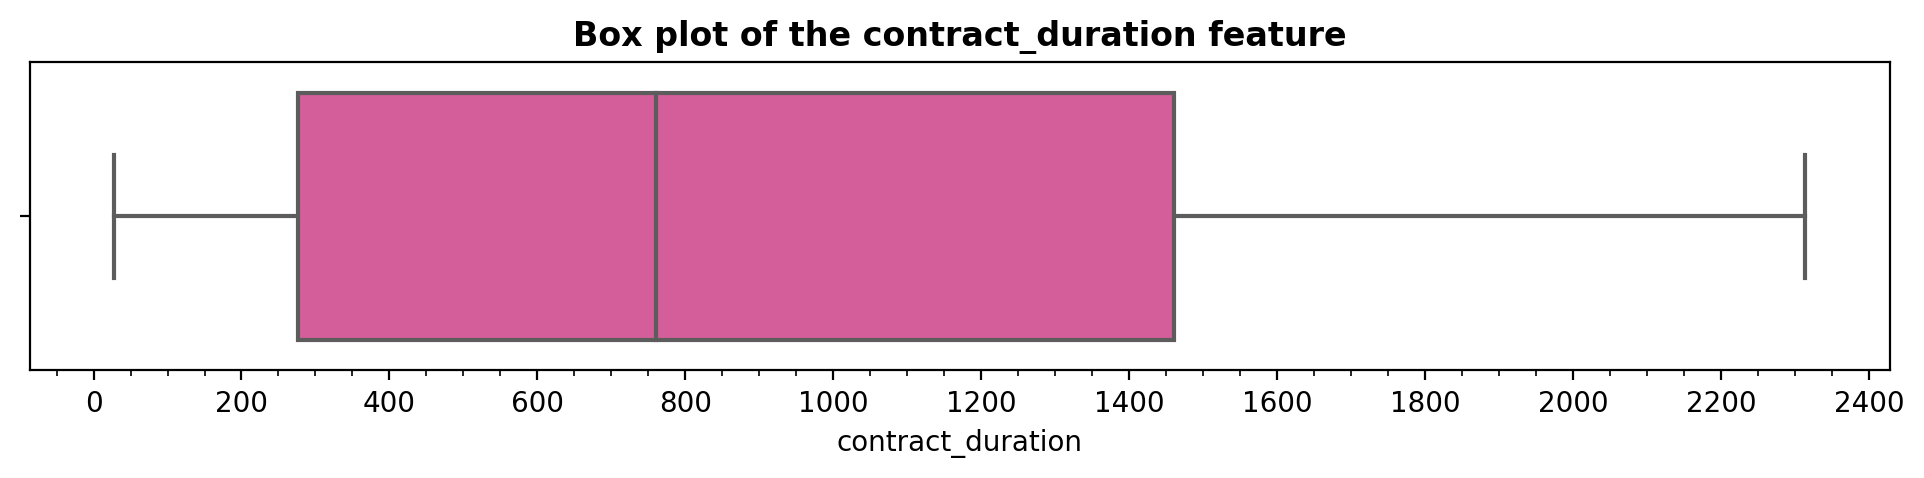

In [31]:
draw_norm_histogram(data=data, 
                    column='contract_duration',
                    major_ticks=200, 
                    minor_ticks=50)
show_description(data=data, column='contract_duration')
draw_boxplot(data=data, column='contract_duration', 
                    major_ticks=200, 
                    minor_ticks=50)

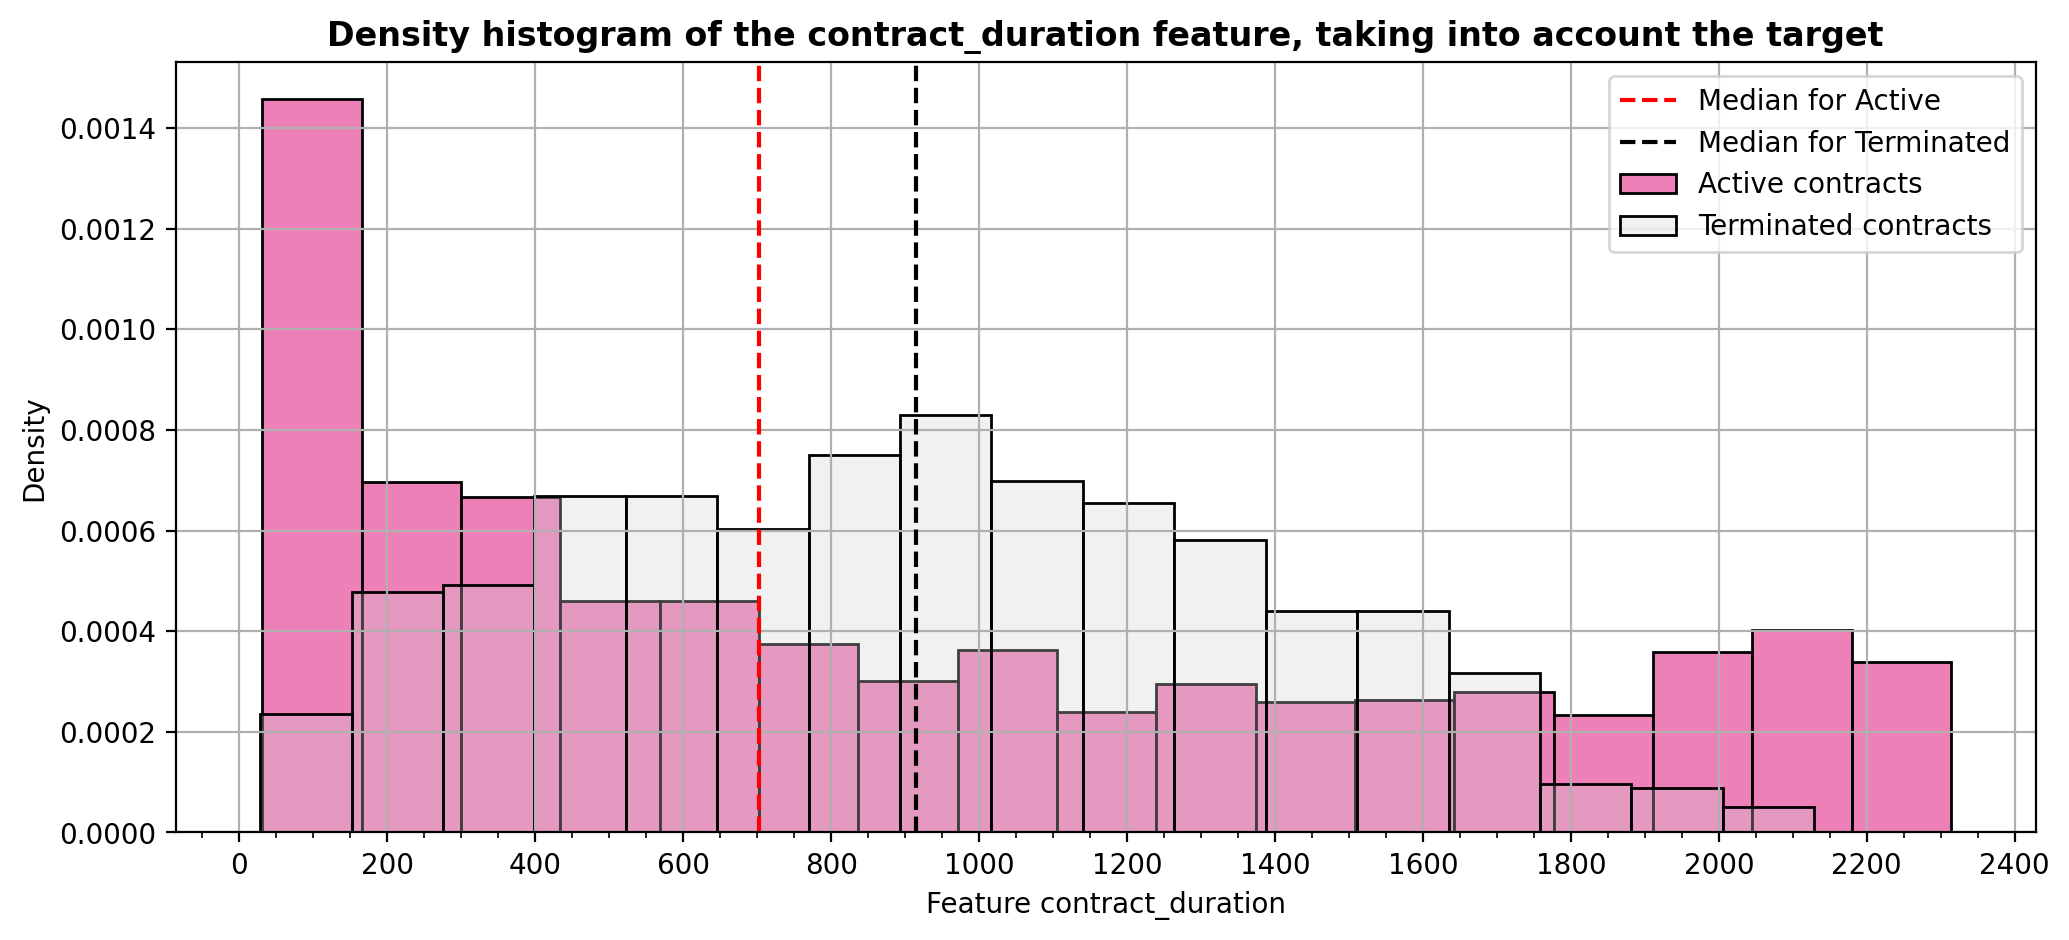

In [32]:
draw_norm_histogram(data=data, 
                    column='contract_duration',
                    major_ticks=200, 
                    minor_ticks=50,
                    target='target_contract_cancelled')

In [33]:
print('Median for Active contracts:',
      data[data['target_contract_cancelled']==0]['contract_duration'].median())
print('Median for Terminated contracts:', 
      data[data['target_contract_cancelled']==1]['contract_duration'].median())

Median for Active contracts: 702.0
Median for Terminated contracts: 915.0


**Observations:**

* The feature is non-normally distributed.
* It takes values from 28 to 2314 days.
* The median value is 761 days.
* The highest density of the distribution is concentrated in the range of the first year of using the services.
* There are no outliers or anomalies observed.
* The median contract duration in days is higher for those clients who terminated the contract. For active contracts, it is 702 days, while for terminated contracts, it is 915 days.

### Number of services

Let's have a look at the average number of services in contracts.

In [34]:
# Columns with service features
services = ['internet_service', 'online_security', 
            'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 
            'streaming_movies', 'multiple_lines', 
            'phone_service']

# Create a copy of the dataset
temp = data.copy(deep=True)

# Value mapping: Yes=1, No=0 
# Count Yes in the service columns
temp[services] = temp[services][services].applymap(lambda x: 1 if x == 'Yes' else 0)
temp['total_yes'] = temp[services].sum(axis=1)

print('Average number of services per user (overall):', 
      round(temp['total_yes'].mean(),2))
print('Average number of services per user (active contracts):', 
      round(temp[temp['target_contract_cancelled']==0]['total_yes'].mean(),2))
print('Average number of services per user (terminated contracts):', 
      round(temp[temp['target_contract_cancelled']==1]['total_yes'].mean(),2))

# Delete the copy
del temp

Average number of services per user (overall): 3.36
Average number of services per user (active contracts): 3.18
Average number of services per user (terminated contracts): 4.35


Average number of services is higher for terminated contrats. This explains the difference in `monthly_charges` and `total_charges`.

### Correlation analysis

Let's examine the relationships between features. Since the dataset contains a large number of categorical features and the numerical features are non-normally distributed, the Spearman correlation method is not suitable. We will use the phi-coefficient matrix instead. It will show whether there are dependencies between parameters, including categorical ones, and can also reveal nonlinear relationships between numerical features.

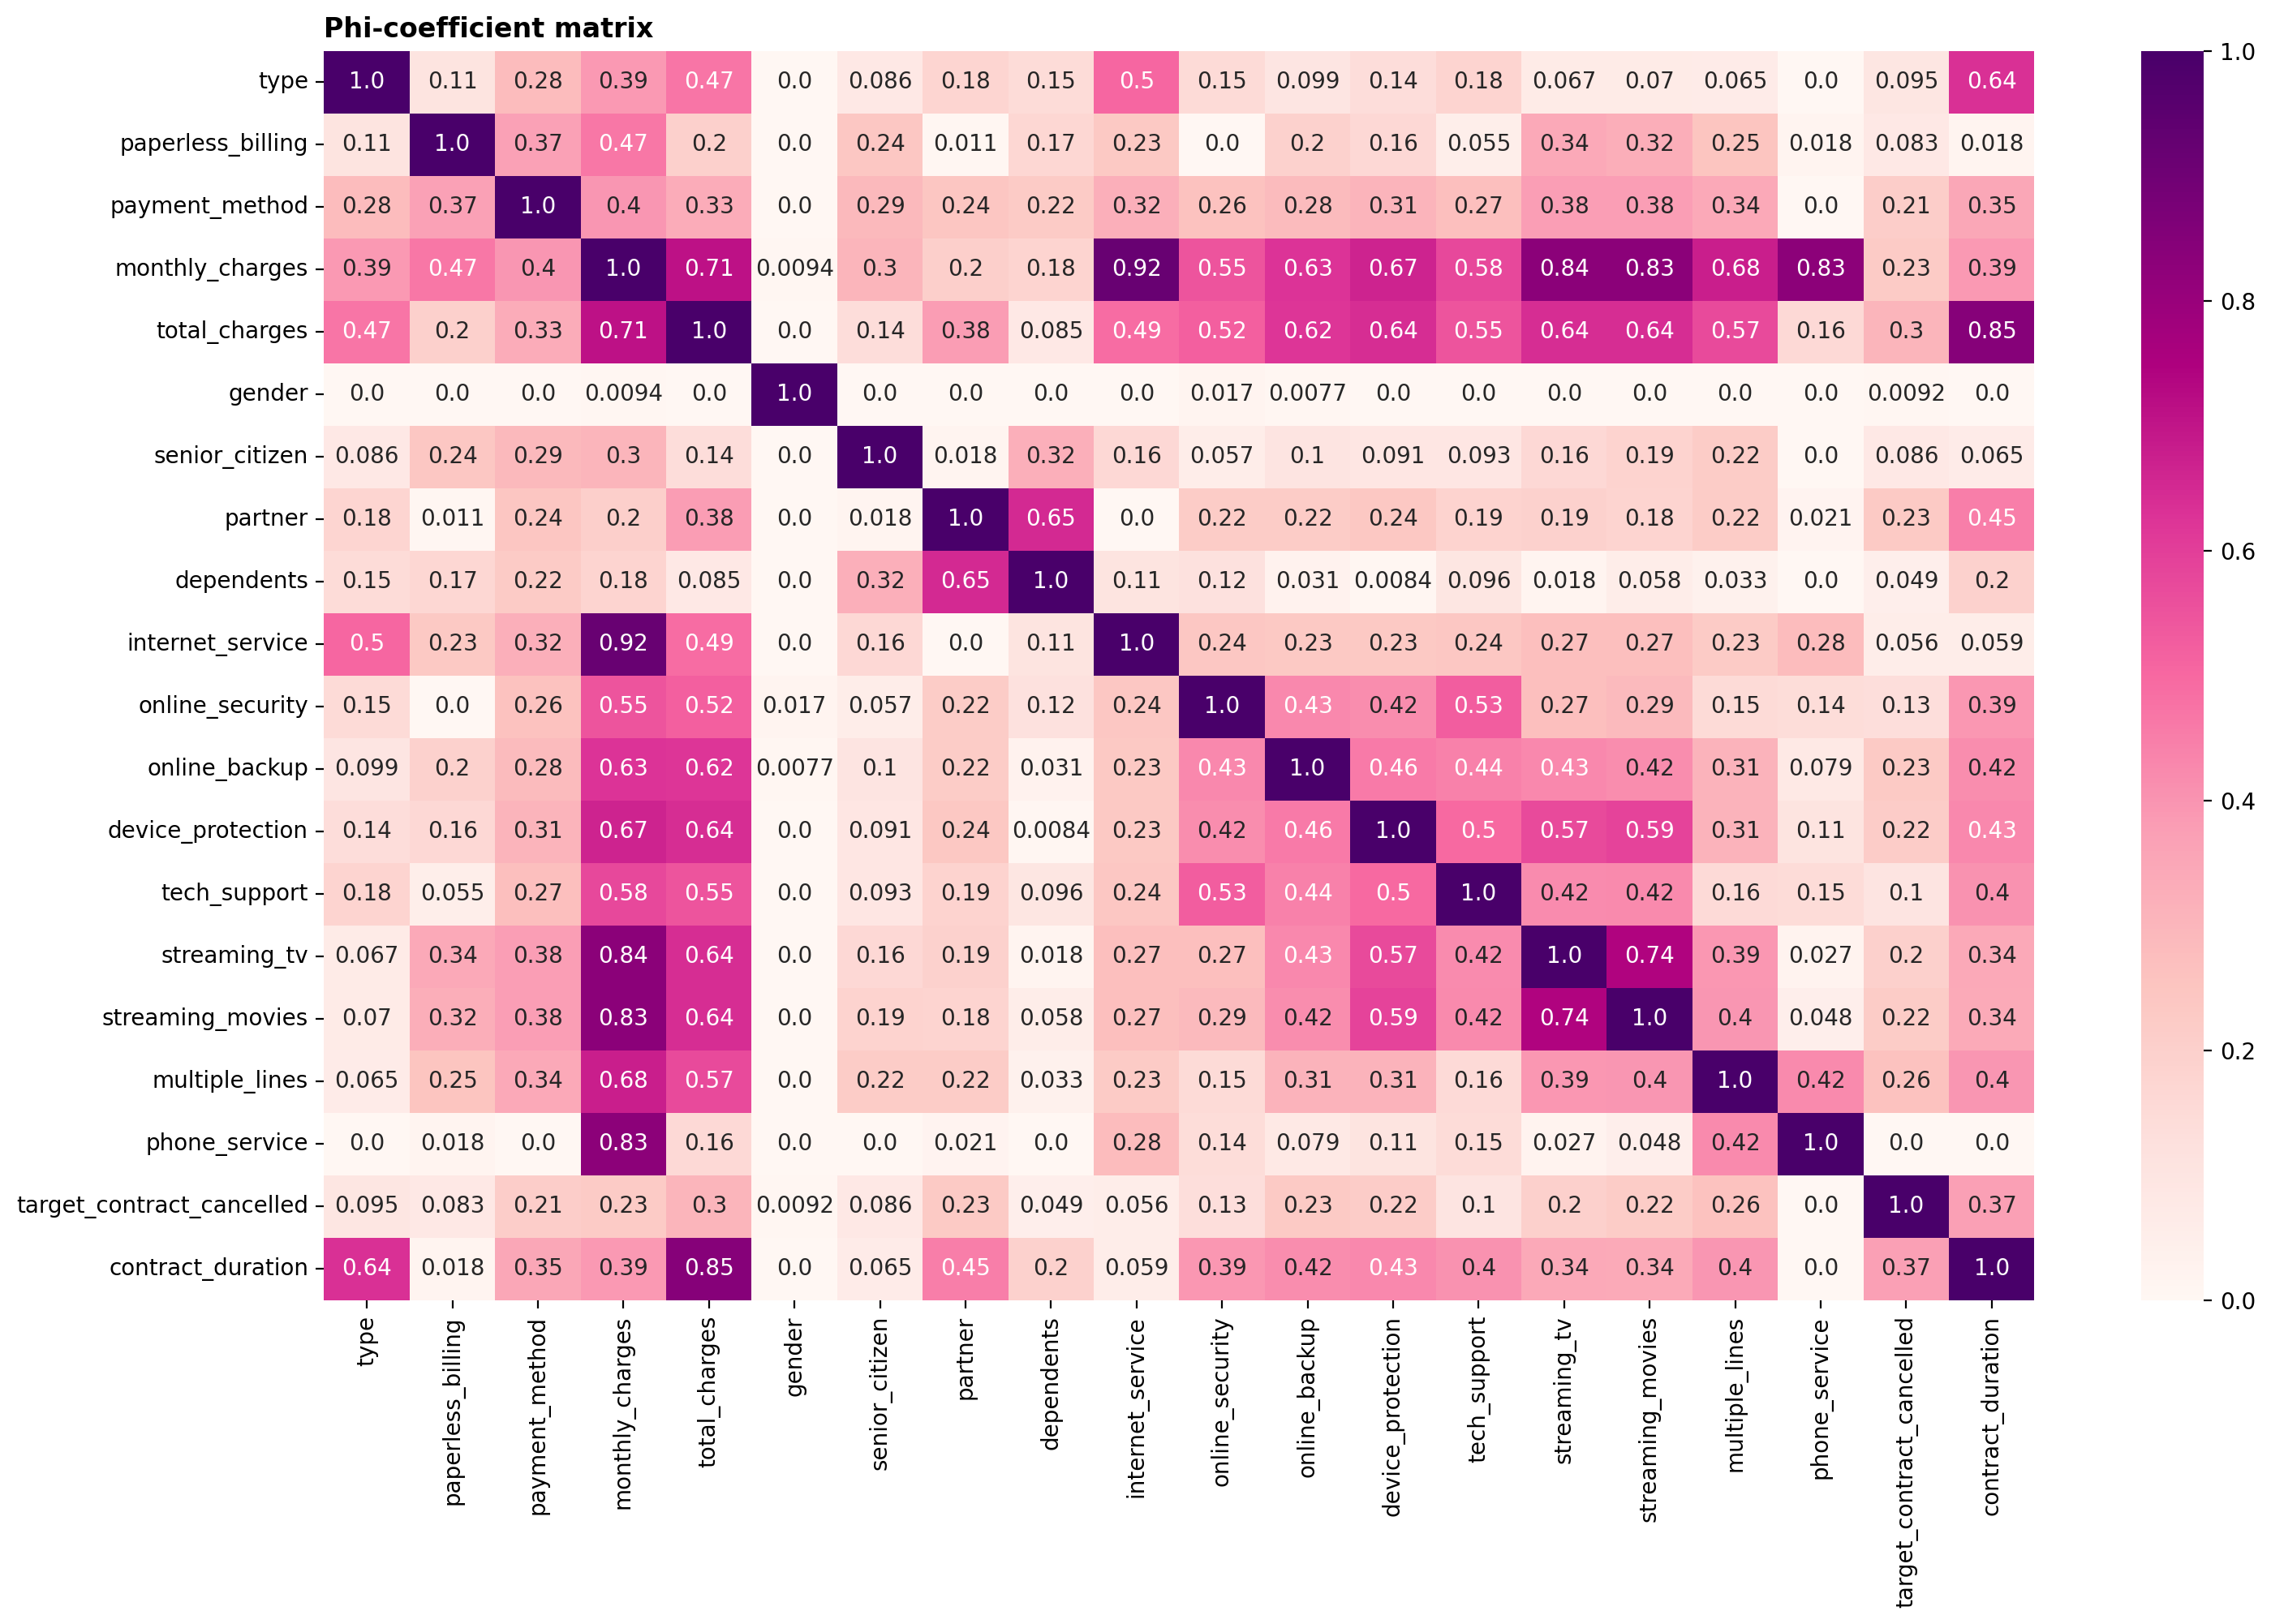

In [35]:
# Phi-coefficient matrix
corr_matrix = data.phik_matrix(interval_cols=['monthly_charges','total_charges', 'contract_duration'])

fig, ax = plt.subplots(figsize = (17,10))
ax.set_title('Phi-coefficient matrix',
             loc='left',
             fontweight='semibold')
ax = sns.heatmap(corr_matrix,
                 xticklabels=corr_matrix.columns.values,
                 yticklabels=corr_matrix.columns.values,
                 vmin=0,
                 vmax=1,
                 cmap='RdPu',
                 annot=True,
                 fmt='.2')
plt.show()

**Observations:**
* None of the input parameters have a strong correlation with the target feature.
* There is a strong correlation between the numerical feature `monthly_charges` and binary features indicating the usage of various services, as well as between the numerical features `total_charges` and `contract_duration`.
* The gender feature does not correlate with the other features, indicating that there is no difference in the behavior of clients based on gender. The feature does not provide value for the model, so we will remove it.

In [36]:
# Delete gender column
data = data.drop(['gender'], axis=1)

### Exploratory Data Analysis Summary

During the exploratory data analysis, we discovered that the median monthly charges for terminated contracts are higher than for active contracts (69.25 and 84.2 respectively), and as a logical consequence, the total charges are also higher for terminated contracts. The median duration of the contract is also higher for terminated contracts (915 days compared to 702). Terminated contracts, on average, include 4 services, while active contracts include 3.

The obtained information can be used for analyzing current and archived tariffs. It's possible that customers find more favorable conditions after two years, so it's necessary to assess how significantly the market conditions change in order to timely adjust the set of services and the price of the offered contract.

## 4. Machine learning models

The problem at hand is a binary classification task. To solve this problem, we will consider logistic regression as a baseline model, k-nearest neighbors (kNN) model, and decision tree based gradient boosting models.

The target quality metric is ROC-AUC >= 0.85 on the test dataset.

### Data preparation for modeling

At this stage, we prepare the data for subsequent model training. First, we split the data into training and testing sets. Since there is class imbalance, we will apply stratification based on the target feature.

In [37]:
# Train/test split
y = data['target_contract_cancelled']
X = data.drop(['target_contract_cancelled'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y)

# Print the size of the sets
print('Rows (clients) in training set:', X_train.shape[0])
print('Columns (features) in training set:', X_train.shape[1], '\n')
print('Rows (clients) in testing set:', X_test.shape[0])
print('Columns (features) in testing set:', X_test.shape[1])

Rows (clients) in training set: 5271
Columns (features) in training set: 18 

Rows (clients) in testing set: 1757
Columns (features) in testing set: 18


Let's create a list of numerical features, a list of categorical features, and a list of indices of columns containing categorical features.

In [38]:
# List of numerical features
num_features = X.select_dtypes(include=np.number).columns.to_list()

# List of categorical features
cat_features = X.select_dtypes(include='category').columns.to_list()

# List of inices of categorical columns
cat_idx = [X.columns.get_loc(column) for column in cat_features]

Next, let's assemble a pipeline for the following models:
* Logistic Regression with Lasso regularization (L1);
* k-Nearest Neighbors (kNN);
* Gradient Boosting based on Decision Trees (using the CatBoost library);
* Gradient Boosting based on Decision Trees (using the LightGBM library).

The pipeline will include the following steps:
1. Preprocessing:
    * For logistic regression model - encoding categorical features using One-Hot Encoding and scaling numerical features using StandardScaler.
    * For kNN model - scaling numerical features only.
    * Boosting libraries have built-in algorithms for encoding categorical features, and decision trees do not require scaling of numerical features, so we will skip this step completely for them.
2. Hyperparameter tuning for the models.

In [39]:
# Preprocessing pipe
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features),
     ('num', StandardScaler(), num_features)
    ],
    remainder='passthrough'
)

# Pipeline with preprocessing and modeling pipes
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    
    # LogisticRegression() parameters
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE,
                                     solver='liblinear',
                                     penalty='l1')],
        'model__C': [0.1, 1, 10]
    },
    
    # KNeighborsClassifier() parameters
    {
        'preprocessor__ohe': [None],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [5, 10]
    },
    
    
    # CatBoostClassifier() parameters
    {
        'preprocessor': [None],
        'model': [CatBoostClassifier(random_state=RANDOM_STATE,
                                     cat_features=cat_features, 
                                     silent=True)],
        'model__learning_rate': [0.1, 0.3, 0.5, 0.7],
        'model__depth': list(range(3, 7)),
    },
    
    # LGBMClassifier() parameters
    {
        'preprocessor': [None],
        'model': [LGBMClassifier(random_state=RANDOM_STATE, 
                                 categorical_feature=cat_idx)],
        'model__learning_rate': [0.1, 0.3, 0.5, 0.7],
        'model__max_depth': list(range(3, 7)),
    }
]

Data preprocessing for modeling is complete, now we can start training models.

### Models training

We are beginning the process of hyperparameter tuning for the models to achieve the maximum ROC-AUC score through cross-validation.

In [40]:
# Parameter tuning and cross-validation
start = time.time()

best_model = RandomizedSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)

best_model.fit(X_train, y_train)

search_time = round(time.time() - start, 2)

print('The search took:', search_time,'seconds.')
print('Best model and its parameters:\n', best_model.best_estimator_)
print('ROC-AUC (cross-validation):', best_model.best_score_.round(3))

The search took: 294.51 seconds.
Best model and its parameters:
 Pipeline(steps=[('preprocessor', None),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000025E67AE67D0>)])
ROC-AUC (cross-validation): 0.917


Let's show the full list of model hyperparameters.

In [41]:
# All hyperparameters
best_model.best_estimator_['model'].get_params()

{'silent': True,
 'random_state': 80424,
 'cat_features': ['type',
  'paperless_billing',
  'payment_method',
  'senior_citizen',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines',
  'phone_service'],
 'learning_rate': 0.3,
 'depth': 3}

The metric during cross-validation meets the required quality level (at least 0.85), so we can proceed to testing.

### Model testing and feature importance analysis

A separate dataset was prepared earlier for model testing. The model will see new data, and we will be able to evaluate whether overfitting occurred.

In [42]:
# Predictions on the test set
y_test_pred_proba = best_model.predict_proba(X_test)
print(f'ROC-AUC (test set): {roc_auc_score(y_test, y_test_pred_proba[:,1]).round(3)}')

ROC-AUC (test set): 0.928


The ROC-AUC quality metric on the test dataset is approximately equal to the metric during cross-validation, indicating that the model did not overfit and has excellent generalization properties.

Let's examine the confusion matrix and the accuracy, recall, and precision metrics to ensure that the model is performing well.

Accuracy: 0.94
Recall: 0.69
Precision: 0.9


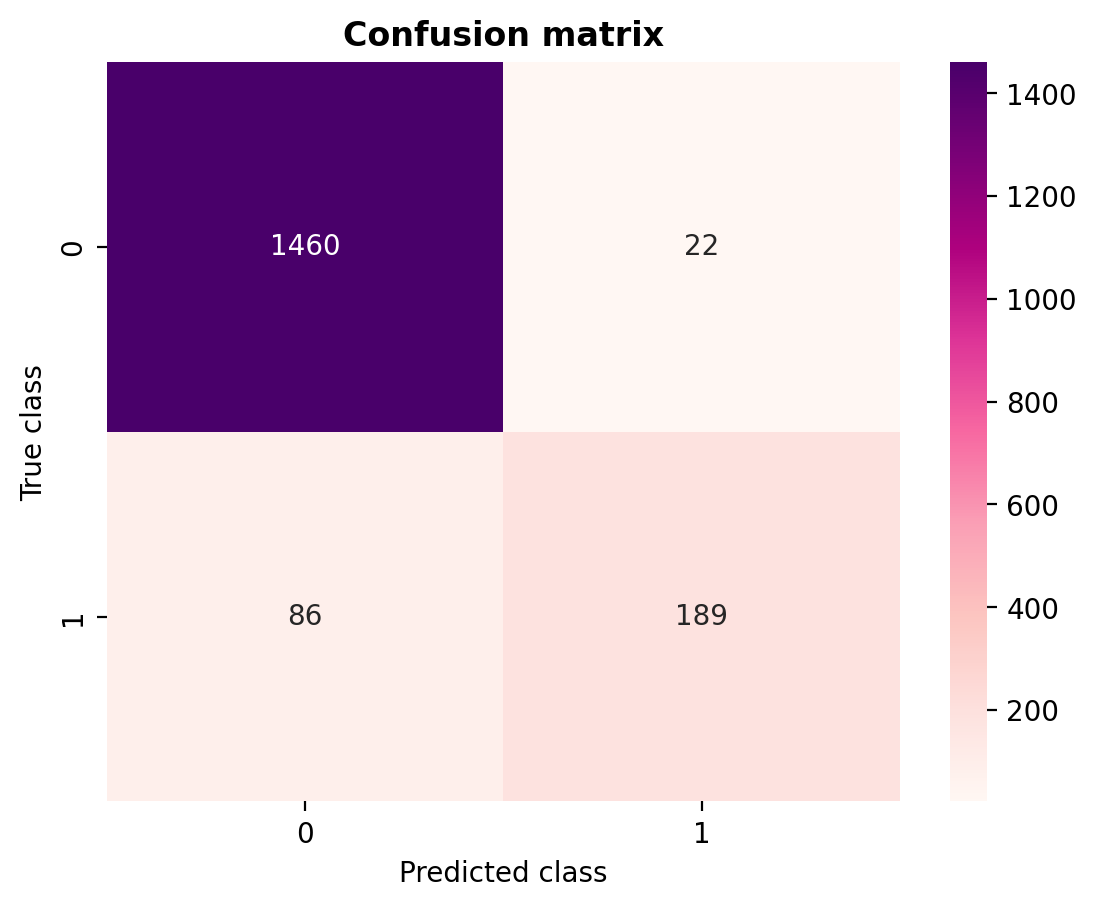

In [43]:
y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title('Confusion matrix', fontweight='semibold')
plt.ylabel('True class')
plt.xlabel('Predicted class');

print('Accuracy:', round(accuracy_score(y_test, y_test_pred),2))
print('Recall:', round(recall_score(y_test, y_test_pred),2))
print('Precision:', round(precision_score(y_test, y_test_pred),2))

* Accuracy = 0.94. This is an excellent result - the model correctly predicts the class in 94% of cases.
* Precision = 0.9. The metric shows the percentage of correct predictions made by the model among all those identified as intending to terminate the contract.
* Recall = 0.69. The metric shows the percentage of users intending to terminate the contract that the model correctly identified.

With this information, the client can reconsider the approach to model quality assessment and optimize the request to suit business needs.

Let's look at the feature importance.

In [44]:
# DF with feature importance
feature_importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': best_model.best_estimator_['model'].feature_importances_.round(2)
    })
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances

,Feature,Importance
0,contract_duration,54.87
1,monthly_charges,13.25
2,total_charges,10.24
3,type,5.62
4,payment_method,3.84
5,multiple_lines,2.06
6,partner,1.91
7,internet_service,1.38
8,online_backup,1.16
9,dependents,0.91


The most important features for the model are:
* `contract_duration`;
* `monthly_charges`;
* `total_charges`;
* `type`.

The importance of individual features related to the usage of services is not high. Perhaps the model can be improved by reducing the number of features and introducing a new one - 'number of services in the contract'.

## 5. Research summary

Our customer's goal is to reduce client churn. To achieve this, we developed a model to predict whether a customer is likely to terminate their contract.

We explored a dataset consisting of 7043 contracts. The collected data was of high quality and did not require significant preprocessing manipulations.

* 4 duplicate rows were removed.
* 11 rows with missing data in `total_charges` were deleted.
* A new numerical feature, `contract_duration`, was created based on the `begin_date` and `end_date` features.
* A target feature, `target_contract_cancelled`, was created based on the `end_date`, taking the value 0 if `end_date` contains No and 1 if it contains the termination date of the contract.
* The `begin_date` and `end_date` features were removed as they were unsuitable for modeling in this task.

During exploratory data analysis, we found that the median monthly charges for terminated contracts were higher than for active contracts (69.25 and 84.2, respectively), leading to higher total charges for terminated contracts. The median duration of terminated contracts was also higher (915 days compared to 702 days for active contracts). Terminated contracts on average included 4 services, while active contracts included 3.

This information can be used to analyze current and archived tariffs. Perhaps customers find better conditions after two years, so it's necessary to assess how significantly market conditions change to adjust the set of services and contract prices accordingly.

For churn prediction, we considered 4 models:
* Logistic Regression with Lasso regularization.
* k Nearest Neighbors.
* Gradient Boosting model based on Decision Trees using the CatBoost library.
* Gradient Boosting model based on Decision Trees using the LightGBM library.

The best model based on cross-validation (ROC-AUC=0.917) was the Gradient Boosting model with the following parameters:
**CatBoostClassifier(random_state=80424, learning_rate=0.3, depth=3, cat_features=['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'phone_service']).**

The model was trained on the following features, in descending order of importance:
* contract_duration;
* monthly_charges;
* total_charges;
* type;
* payment_method;
* multiple_lines;
* partner;
* internet_service;
* online_backup;
* dependents;
* online_security;
* phone_service;
* device_protection;
* senior_citizen;
* paperless_billing;
* tech_support;
* streaming_tv;
* streaming_movies.

The first five features are significantly more important for the model than the rest.

Results of model testing:
* ROC-AUC metric on the test set: 0.928. The model meets the customer's requirements.
* Accuracy = 0.94. The model correctly predicts the class in 94% of cases.
* Precision = 0.9. The percentage of correct predictions made by the model among all those identified as intending to terminate the contract.
* Recall = 0.69. The percentage of users intending to terminate the contract that the model correctly identified.

**Recommendations for further model improvement:**

Since the goal is to reduce churn, it is recommended to reconsider the model evaluation metric and focus on minimizing type II errors (false negatives), i.e., use Recall as the primary metric. Alternatively, create a custom metric that equally considers ROC-AUC and Recall.